# IRIS Flower Classification

## Introduction

The Iris dataset is a popular choice for classification tasks in machine learning. It contains measurements of four features (sepal length, sepal width, petal length, and petal width) of iris flowers belonging to three different species: setosa, versicolor, and virginica.

Our goal is to build a machine learning model that can accurately classify iris flowers into their respective species based on these four features. This is a supervised learning problem, as we have labeled data with the correct species for each sample. Since we are predicting a categorical variable (the species), this is a classification task.

We will explore different classification algorithms, such as k-nearest neighbors, decision trees, and logistic regression, to determine which model performs best on the Iris dataset. By the end of this project, we aim to build a model that can accurately classify iris flowers based on their measurements.


## Table of Contents
---
- [Introduction](#Introduction)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Data Cleaning](#Data-Cleaning)
- [Data Visualization](#Data-Visualization)
- [Data Preprocessing](#Data-Preprocessing)
- [Model Preparation](#Model-Preparation)
- [Model Results](#Model-Results)
  - [Decision Tree](#Decision-Tree)
  - [KNN](#KNN)
  - [Random Forest](#Random-Forest)
  - [Support Vector Machine](#Support-Vector-Machine)
  - [Gradient Boosting](#Gradient-Boosting)
- [Best Performing Model](#Best-Performing-Model)  
- [Partial Dependence Plots](#Partial-Dependence-Plots)
- [Discussion and Recommendations](#Discussion-and-Recommendations)

## Introduction

## Exploratory Data Analysis
We start by installing the necessary modules and importing the necessary libraries.

In [1]:
%%capture
!pip install pandas
!pip install sqlite3
!pip install sqlalchemy
!pip install scikit-learn
!pip install seaborn
!pip install matplotlib

In [2]:
# Process and Visualize data
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from scipy import stats, interp
from sqlalchemy import create_engine
import seaborn as sns

# Preprocess data
from sklearn.preprocessing import LabelEncoder, label_binarize, OneHotEncoder, StandardScaler

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, make_scorer, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.svm import LinearSVC

# Read the full contents of the dataframes
pd.set_option('display.max_colwidth', None)
pd.options.display.max_columns = None

Next, we will load the data into a SQLite database. We will be working with the [Iris Dataset](https://archive.ics.uci.edu/dataset/53/iris) from the UC Irvine Machine Learning Repository. This dataset contains plant information in a file named `IRIS.csv`.

In [3]:
# Load the IRIS CSV file into a DataFrame
iris_df = pd.read_csv("IRIS.csv")

# Create an SQLite engine
engine = create_engine('sqlite:///iris.db')

# Load the DataFrame into the SQLite database
iris_df.to_sql('iris', engine, index=False, if_exists='replace')

# Look at shape of the dataframe
iris_df.shape


(152, 5)

In [4]:
iris_df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [5]:
iris_df.columns

Index(['sepal_length', 'sepal_width', 'petal_length', 'petal_width',
       'species'],
      dtype='object')

In [6]:
iris_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152 entries, 0 to 151
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  152 non-null    float64
 1   sepal_width   152 non-null    float64
 2   petal_length  152 non-null    object 
 3   petal_width   152 non-null    object 
 4   species       151 non-null    object 
dtypes: float64(2), object(3)
memory usage: 6.1+ KB


We can see that there are 152 records and 5 columns. Four columns are numeric and represent continuous data while the `species` column is categorical and stores one of three different flower types (setosa, versicolour, and virginica). The column data is as follows:

- `sepal_length:` the sepal length (in cm)
- `sepal_width:` the sepal width (in cm)
- `petal_length:` the petal length (in cm)
- `petal_width:` the pedal width (in cm)
- `species:` the type of flower (one of setosa, versicolour, or virginica)

## Cleaning the Data

We will now examine null records.

In [7]:
# Check for missing values
missing_values = iris_df.isna().sum()
print("Missing values in each column:\n", missing_values)

Missing values in each column:
 sepal_length    0
sepal_width     0
petal_length    0
petal_width     0
species         1
dtype: int64


In [8]:
# Determine rows with null values
null_rows = iris_df[iris_df.isna().any(axis=1)]
print(null_rows)

    sepal_length  sepal_width petal_length  petal_width species
22           3.7          1.5          0.4  Iris-setosa     NaN


The species in row 22 is missing. From reviewing other data, we can see that the species was put inside the `pedal_width` column and that we should shift the other columns to the right and replace the `sepal_length` column. We now fix the missing values.

In [9]:
# Calculate the average sepal length
avg_sepal_length = iris_df['sepal_length'].mean()

# Define a function to shift columns to the right for rows with null species
def shift_row(row):
    if pd.isnull(row['species']):
        return pd.Series([row['petal_width'], row['petal_length'],
                          row['sepal_width'], row['sepal_length'],
                          avg_sepal_length],
                         index=['species', 'petal_width', 'petal_length',
                                'sepal_width', 'sepal_length'])
    return row


# Apply the function to each row
iris_df = iris_df.apply(shift_row, axis=1)

# Confirm no missing values remain
missing_values_after = iris_df.isnull().sum()
print("Missing values after handling:\n", missing_values_after)

Missing values after handling:
 petal_length    0
petal_width     0
sepal_length    0
sepal_width     0
species         0
dtype: int64


We now re-examine row 22.

In [10]:
print(iris_df.iloc[22])

petal_length            1.5
petal_width             0.4
sepal_length       5.831579
sepal_width             3.7
species         Iris-setosa
Name: 22, dtype: object


Let's also make sure that all of the numerical columns have valid numerical data. If these aren't valid numerical data, we will replace the data with the column mean.

In [11]:
def convert_columns_to_numeric(df, columns):
    """
    Convert specified columns of a DataFrame to numeric, coercing errors to NaN.

    Parameters:
    df (pandas.DataFrame): The DataFrame containing the columns to convert.
    columns (list of str): The list of column names to convert to numeric.

    Returns:
    pandas.DataFrame: The DataFrame with specified columns converted to numeric.
    """
    for column in columns:
        df[column] = pd.to_numeric(df[column], errors='coerce')
    return df

# Specify the features to convert
features = ['petal_length', 'petal_width', 'sepal_length', 'sepal_width']

# Convert the specified columns to numeric
iris_df = convert_columns_to_numeric(iris_df, features)

In [12]:
# Calculate the mean of the 'pedal length' column, ignoring NaN values
mean_pedal_length = iris_df['petal_length'].mean()

# Replace NaN values (which were originally strings like "A") with the mean
iris_df['petal_length'].fillna(mean_pedal_length, inplace=True)

Let's also handle outliers.

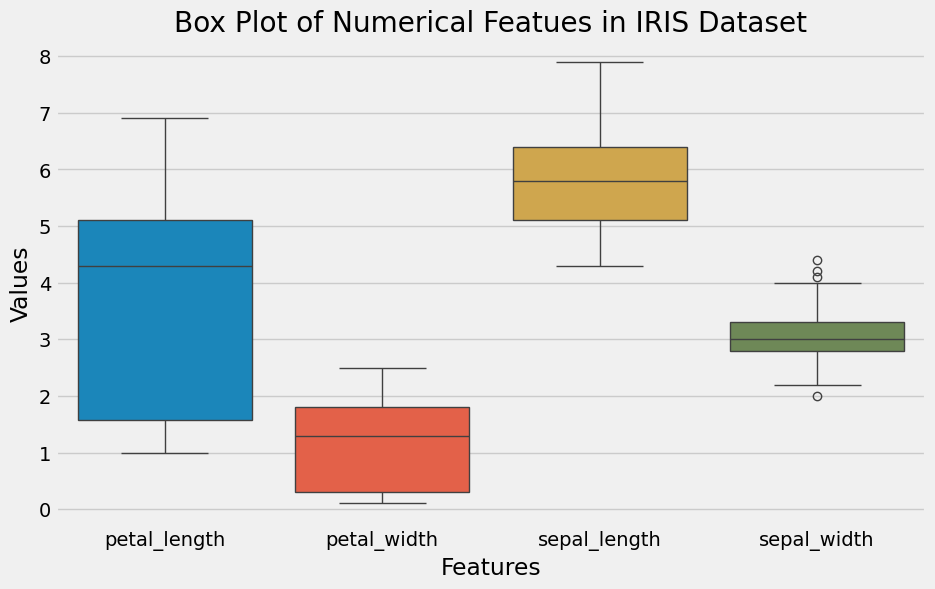

In [13]:
# Create a box plot for all numerical columns
plt.figure(figsize=(10, 6))
sns.boxplot(data=iris_df[features])
plt.title('Box Plot of Numerical Featues in IRIS Dataset')
plt.xlabel('Features')
plt.ylabel('Values')
plt.show()

Let's handle the outliers in the sepal width feature. There are four outliers.

In [14]:
# Calculate the IQR for sepal width
q1 = iris_df['sepal_width'].quantile(0.25)
q3 = iris_df['sepal_width'].quantile(0.75)
iqr = q3 - q1

# Calculate the lower and upper bounds for outliers
lof = q1 - 1.5 * iqr
ufo = q3 + 1.5 * iqr

# Identify the outliers
outliers1 = iris_df[iris_df['sepal_width'] < lof]
outliers2 = iris_df[iris_df['sepal_width'] > ufo]

# Combine the outliers using concat
outliers = pd.concat([outliers1, outliers2])

# Print the results
print(f"Lower Outlier Fence (LOF): {lof}")
print(f"Upper Outlier Fence (UFO): {ufo}")
print("Outliers:")
print(outliers)

Lower Outlier Fence (LOF): 2.05
Upper Outlier Fence (UFO): 4.05
Outliers:
    petal_length  petal_width  sepal_length  sepal_width          species
61           3.5          1.0           5.0          2.0  Iris-versicolor
15           1.5          0.4           5.7          4.4      Iris-setosa
33           1.5          0.1           5.2          4.1      Iris-setosa
34           1.4          0.2           5.5          4.2      Iris-setosa


However, these look fine from our histogram. We will not remove these four outliers.

<Axes: xlabel='sepal_width', ylabel='Count'>

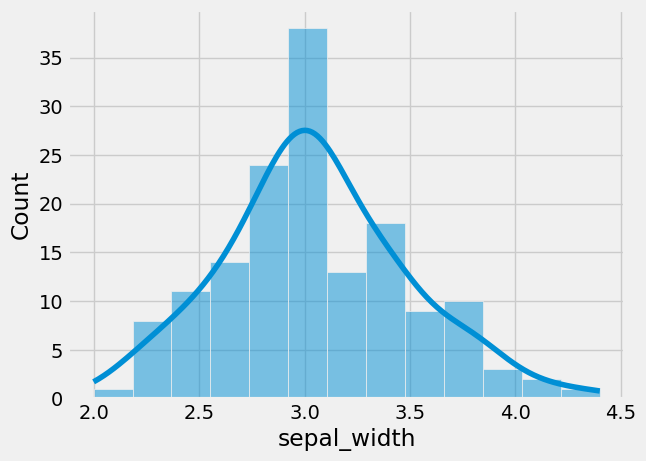

In [15]:
sns.histplot(iris_df['sepal_width'], kde=True)

## Reviewing Summary Statistics

In [16]:
# Generate summary statistics
summary_stats = iris_df.describe()
print("Summary Statistics:\n", summary_stats)

# Check for unique values in categorical column
unique_species = iris_df['species'].unique()
print("Unique species:\n", unique_species)

Summary Statistics:
        petal_length  petal_width  sepal_length  sepal_width
count    152.000000   152.000000    152.000000   152.000000
mean       3.743709     1.195395      5.845602     3.052632
std        1.762245     0.761259      0.823073     0.439438
min        1.000000     0.100000      4.300000     2.000000
25%        1.575000     0.300000      5.100000     2.800000
50%        4.300000     1.300000      5.800000     3.000000
75%        5.100000     1.800000      6.400000     3.300000
max        6.900000     2.500000      7.900000     4.400000
Unique species:
 ['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']


In [17]:
iris_df.describe().T

,count,mean,std,min,25%,50%,75%,max
petal_length,152.0,3.743709,1.762245,1.0,1.575,4.3,5.1,6.9
petal_width,152.0,1.195395,0.761259,0.1,0.300,1.3,1.8,2.5
sepal_length,152.0,5.845602,0.823073,4.3,5.100,5.8,6.4,7.9
sepal_width,152.0,3.052632,0.439438,2.0,2.800,3.0,3.3,4.4


## Exploring the Data


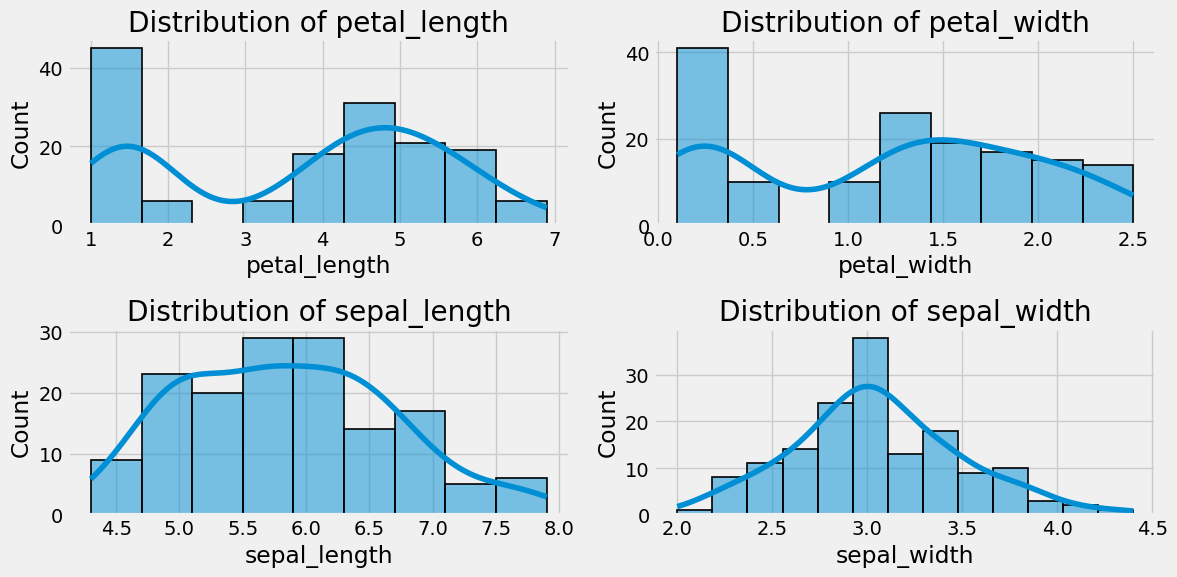

In [18]:
# Plot histograms with KDE for each feature column
plt.figure(figsize=(12, 6))
for i, column in enumerate(features, 1):
    plt.subplot(2, 2, i)
    sns.histplot(iris_df[column], kde=True, edgecolor='black', linewidth=1.2)
    plt.title(f'Distribution of {column}')
plt.tight_layout()
plt.show()

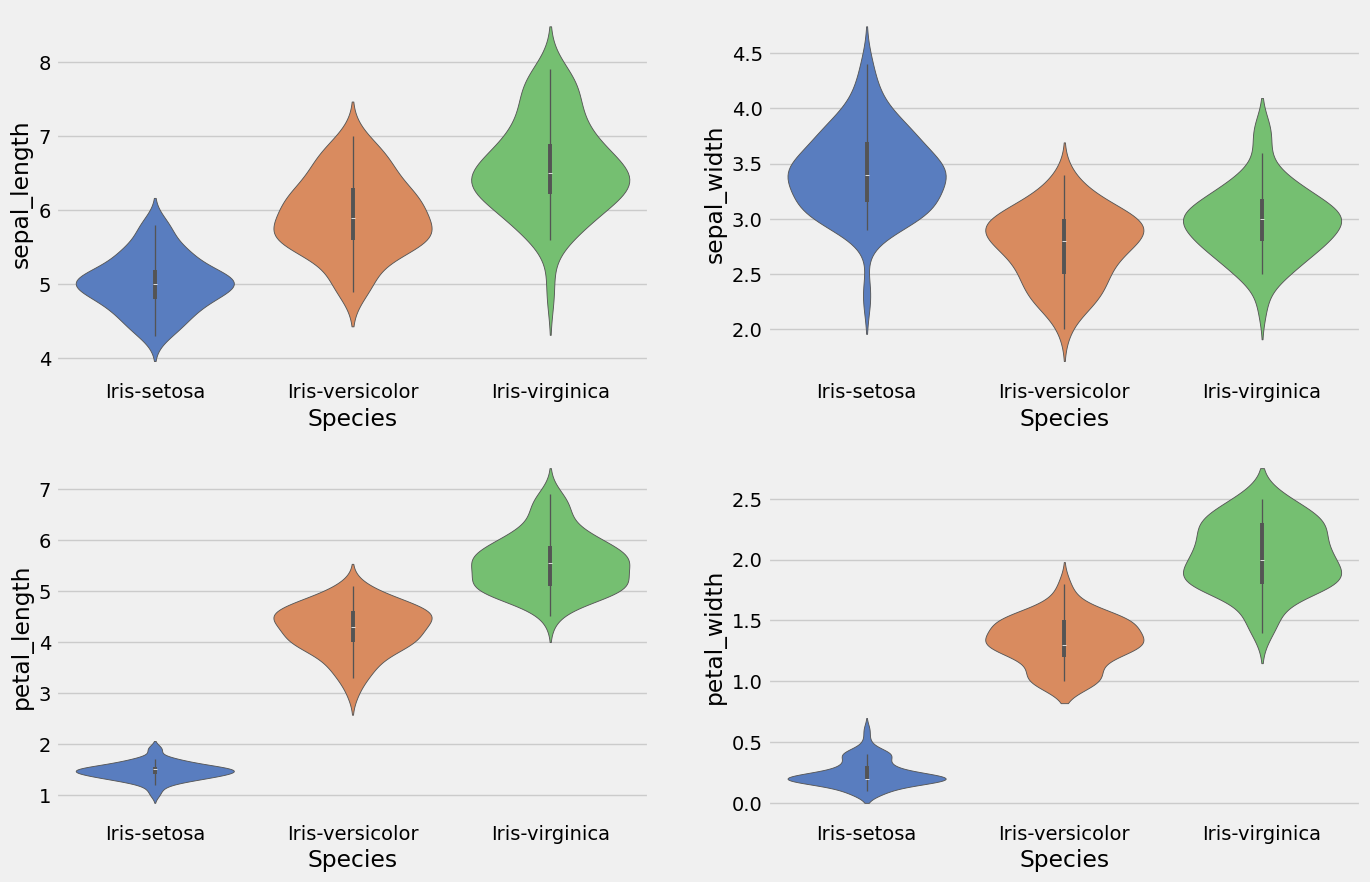

In [19]:
# Define a function to create a violin plot
def plot_violin(subplot_position, y):
    plt.subplot(subplot_position)
    ax = sns.violinplot(x='species', y=y, data=iris_df, hue='species', palette='muted', legend=False)
    ax.set_xlabel('Species')

# Set up the figure size
plt.figure(figsize=(15, 10))

# Define features for the plots
features = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

# Create the violin plots
for i, feature in enumerate(features, start=1):
    plot_violin(220 + i, feature)

## Data Preprocessing

In [20]:
# Encode the species column into numerical values
le = LabelEncoder()
iris_df['species'] = le.fit_transform(iris_df['species'].astype(str))

iris_df['species'] = le.inverse_transform(iris_df['species'])

print(iris_df['species'].value_counts())
print('\n{}'.format(iris_df.info()))

species
Iris-setosa        51
Iris-versicolor    51
Iris-virginica     50
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152 entries, 0 to 151
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   petal_length  152 non-null    float64
 1   petal_width   152 non-null    float64
 2   sepal_length  152 non-null    float64
 3   sepal_width   152 non-null    float64
 4   species       152 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.1+ KB

None


We will now use a heatmap to visualize correlation between columns. We will look at the correlation between all numerical columns and the `species` column (which will be the target variable in our machine learning models).

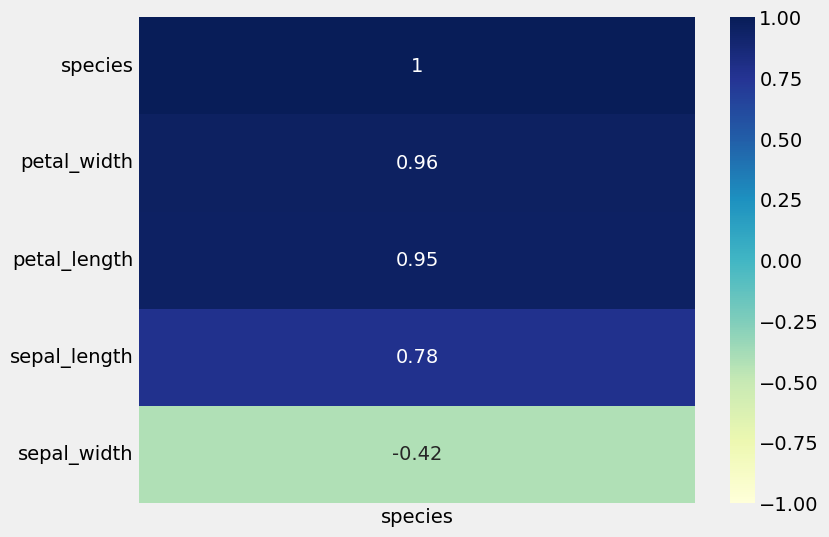

In [26]:
# Convert the species column to numerical values
iris_df['species'] = le.fit_transform(iris_df['species'].astype(str))

fig, ax = plt.subplots(figsize=(8,6))
corr_matrix = np.abs(iris_df.corr())
sns.heatmap(iris_df.corr()[['species']].sort_values('species').tail(10),
 vmax=1, vmin=-1, cmap='YlGnBu', annot=True, ax=ax);
ax.invert_yaxis()

Here we see that highly correlated features are `petal_width`, `pedal_length`, and `sepal_length.` Features that are less correlated are `sepal_width`. For now, we will not drop these columns.

## Model Preparation

We will now separate our data into features and a target. We will choose the flower species as our target variable. The features will be the remaining four columns which we will use to predict the flower species.

Next, we are going to split our data into train and test and look at the shape of the resulting datasets.

In [27]:
X = iris_df.drop('species', axis=1)
y = iris_df['species']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print("Size of X_train: ", X_train.shape)
print("Size of X_test: ", X_test.shape)
print("Size of y_train: ", y_train.shape)
print("Size of y_test: ", y_test.shape)

Size of X_train:  (106, 4)
Size of X_test:  (46, 4)
Size of y_train:  (106,)
Size of y_test:  (46,)


Before we start building various machine learning models, we will look at a baseline model to see how well our models perform. Our baseline will be to predict all flowers as one of the three types. Say that we predict all of the flowers are of type `setosa`.

In [28]:
# Set all predictions to be 'setosa'
y_pred_setosa = [0] * len(y)

# Calculate the accuracy
accuracy = accuracy_score(y, y_pred_setosa)

print("Accuracy of predicting all flower species as 'setosa': {:.2f}%".format(accuracy * 100))

Accuracy of predicting all flower species as 'setosa': 33.55%


Then, we see that our machine learning models are only useful if they can achieve an accuracy better than 33%.

## Model Results

Let's test several ensemble methods to investigate the performance of different classification algorithms. We will first use a Pipeline to standardize our numerical features.

In [29]:
numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

# Classifiers for ensemble learning and others
classifiers = {
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Support Vector Machine': LinearSVC(),
    'Decision Tree': DecisionTreeClassifier(),
    'Bagging Decision Tree (Ensemble)': BaggingClassifier(DecisionTreeClassifier(), max_samples=0.5, max_features=1.0, n_estimators=10),
    'Boosting Decision Tree (Ensemble)': AdaBoostClassifier(DecisionTreeClassifier(min_samples_split=10, max_depth=4),
                                     n_estimators=10, learning_rate=0.6),
    'Random Forest (Ensemble)': RandomForestClassifier(n_estimators=30, max_depth=8),
    'Voting Classifier (Ensemble)': VotingClassifier(estimators=[
        ('lr', LogisticRegression(max_iter=1000)),
        ('rf', RandomForestClassifier(n_estimators=30, max_depth=8)),
        ('svm', LinearSVC())
    ], voting='hard')
}

In [30]:
scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted'),
}

results = []
for label, clf in classifiers.items():
    start = datetime.datetime.now()
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', clf)
    ])
    scores = cross_val_score(pipeline, X_train, y_train, scoring='accuracy', cv=5, n_jobs=-1)
    precision = cross_val_score(pipeline, X_train, y_train, scoring=scoring['precision'], cv=5, n_jobs=-1)
    recall = cross_val_score(pipeline, X_train, y_train, scoring=scoring['recall'], cv=5, n_jobs=-1)
    f1 = cross_val_score(pipeline, X_train, y_train, scoring=scoring['f1'], cv=5, n_jobs=-1)

    pipeline.fit(X_train, y_train)
    cv_time = str(datetime.datetime.now() - start)[:-3]

    result_dict = {
        'Model': label,
        'Train Accuracy': pipeline.score(X_train, y_train),
        'Test Accuracy': pipeline.score(X_test, y_test),
        'Max CrossVal': scores.max(),
        'Precision': precision.mean(),
        'Recall': recall.mean(),
        'F1 Score': f1.mean(),
        'Timespan': cv_time
    }
    results.append(result_dict)

output = pd.DataFrame(results)
output = output.sort_values(by='Test Accuracy', ascending=False).reset_index(drop=True)
output

,Model,Train Accuracy,Test Accuracy,Max CrossVal,Precision,Recall,F1 Score,Timespan
0,Logistic Regression,0.990566,0.934783,1.0,0.972487,0.971429,0.971276,0:00:00.967
1,Support Vector Machine,0.962264,0.934783,1.0,0.945408,0.942857,0.943004,0:00:00.627
2,Voting Classifier (Ensemble),0.990566,0.934783,1.0,0.964153,0.961905,0.961752,0:00:02.105
3,K-Nearest Neighbors,0.981132,0.913043,1.0,0.983069,0.980952,0.980713,0:00:06.261
4,Bagging Decision Tree (Ensemble),0.990566,0.913043,1.0,0.983069,0.952814,0.980800,0:00:01.556
5,Boosting Decision Tree (Ensemble),1.000000,0.913043,1.0,0.956073,0.952814,0.952530,0:00:00.947
6,Random Forest (Ensemble),1.000000,0.913043,1.0,0.974868,0.961905,0.971276,0:00:04.372
7,Decision Tree,1.000000,0.891304,1.0,0.956073,0.952814,0.952732,0:00:00.884


The Logistic Regression model had the highest test accuracy.

In [31]:
Highest_Test_Accuracy = output.sort_values(by= 'Test Accuracy',ascending= False).Model
Highest_Test_Accuracy

0                  Logistic Regression
1               Support Vector Machine
2         Voting Classifier (Ensemble)
3                  K-Nearest Neighbors
4     Bagging Decision Tree (Ensemble)
5    Boosting Decision Tree (Ensemble)
6             Random Forest (Ensemble)
7                        Decision Tree
Name: Model, dtype: object

The Bagging Decision Tree had the highest F1 score.

In [34]:
Highest_F1_Score = output.sort_values(by= 'F1 Score',ascending= False).Model
Highest_F1_Score

4     Bagging Decision Tree (Ensemble)
3                  K-Nearest Neighbors
0                  Logistic Regression
6             Random Forest (Ensemble)
2         Voting Classifier (Ensemble)
7                        Decision Tree
5    Boosting Decision Tree (Ensemble)
1               Support Vector Machine
Name: Model, dtype: object

Also, the Support Vector Machine method took the least amount of processing time.

In [32]:
Fastest = output.sort_values(by= 'Timespan').Model
Fastest

1               Support Vector Machine
7                        Decision Tree
5    Boosting Decision Tree (Ensemble)
0                  Logistic Regression
4     Bagging Decision Tree (Ensemble)
2         Voting Classifier (Ensemble)
6             Random Forest (Ensemble)
3                  K-Nearest Neighbors
Name: Model, dtype: object

### Confusion Matrices

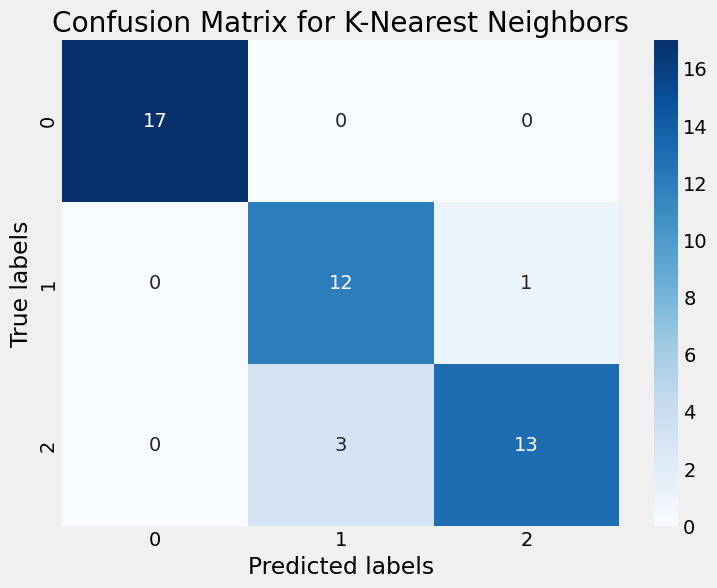

Classification Report for K-Nearest Neighbors:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       0.80      0.92      0.86        13
           2       0.93      0.81      0.87        16

    accuracy                           0.91        46
   macro avg       0.91      0.91      0.91        46
weighted avg       0.92      0.91      0.91        46



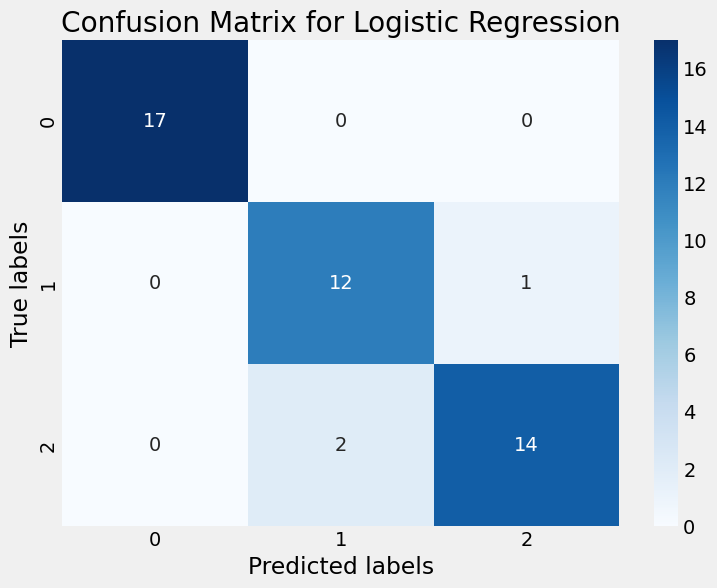

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       0.86      0.92      0.89        13
           2       0.93      0.88      0.90        16

    accuracy                           0.93        46
   macro avg       0.93      0.93      0.93        46
weighted avg       0.94      0.93      0.93        46



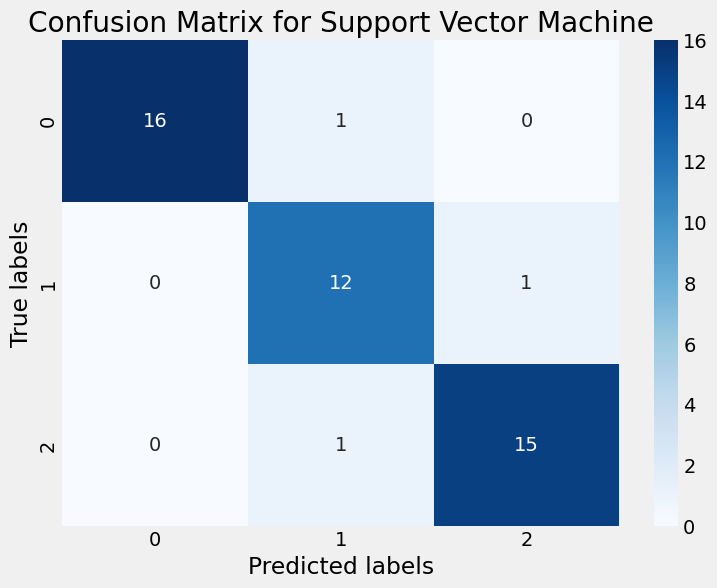

Classification Report for Support Vector Machine:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        17
           1       0.86      0.92      0.89        13
           2       0.94      0.94      0.94        16

    accuracy                           0.93        46
   macro avg       0.93      0.93      0.93        46
weighted avg       0.94      0.93      0.94        46



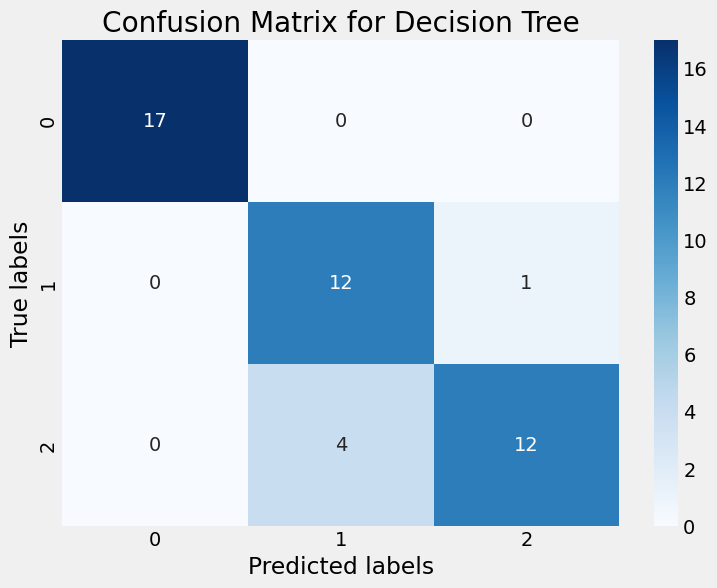

Classification Report for Decision Tree:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       0.75      0.92      0.83        13
           2       0.92      0.75      0.83        16

    accuracy                           0.89        46
   macro avg       0.89      0.89      0.89        46
weighted avg       0.90      0.89      0.89        46



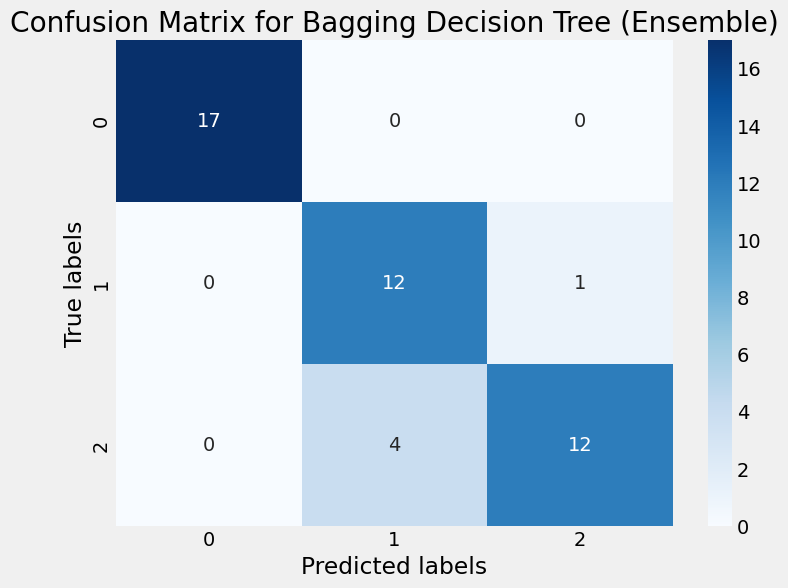

Classification Report for Bagging Decision Tree (Ensemble):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       0.75      0.92      0.83        13
           2       0.92      0.75      0.83        16

    accuracy                           0.89        46
   macro avg       0.89      0.89      0.89        46
weighted avg       0.90      0.89      0.89        46



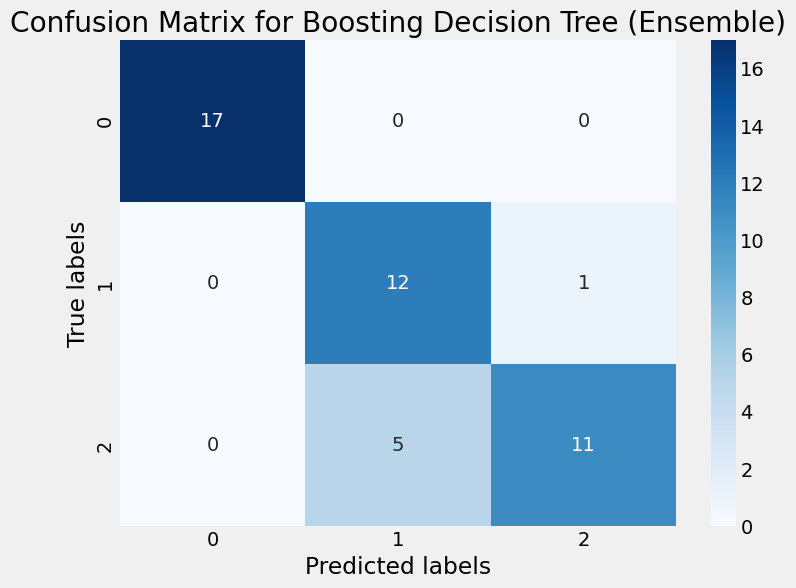

Classification Report for Boosting Decision Tree (Ensemble):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       0.71      0.92      0.80        13
           2       0.92      0.69      0.79        16

    accuracy                           0.87        46
   macro avg       0.87      0.87      0.86        46
weighted avg       0.89      0.87      0.87        46



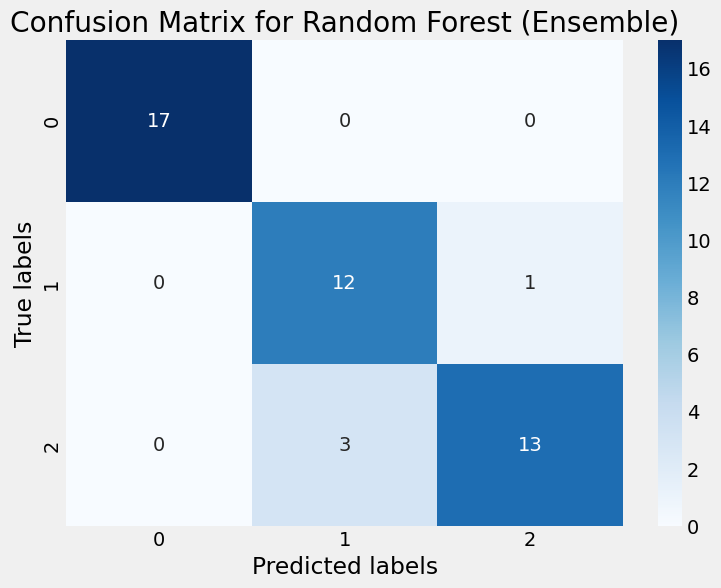

Classification Report for Random Forest (Ensemble):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       0.80      0.92      0.86        13
           2       0.93      0.81      0.87        16

    accuracy                           0.91        46
   macro avg       0.91      0.91      0.91        46
weighted avg       0.92      0.91      0.91        46



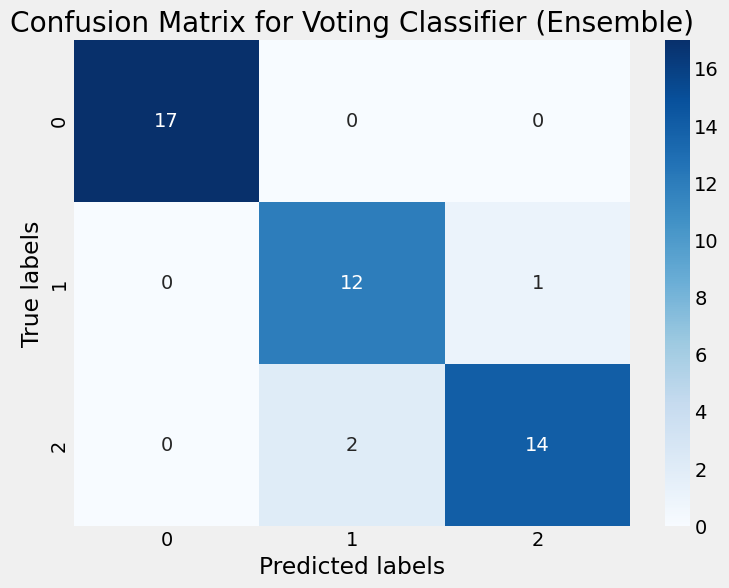

Classification Report for Voting Classifier (Ensemble):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       0.86      0.92      0.89        13
           2       0.93      0.88      0.90        16

    accuracy                           0.93        46
   macro avg       0.93      0.93      0.93        46
weighted avg       0.94      0.93      0.93        46



In [33]:
for label, clf in classifiers.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', clf)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'Confusion Matrix for {label}')
    plt.show()

    # Classification Report
    report = classification_report(y_test, y_pred)
    print(f'Classification Report for {label}:')
    print(report)

### Dimensionality Reduction

### Best Performing Model

## Conclusions